# Issue
- 現状のまとめ
    - entanglement を増やすとさらに低い固有状態を見つける場合があるが、必ずしもラウンドされた結果に反映されない
    - Pauli rounding の場合はむしろ低い状態を見つけたことでラウンドの精度が悪化しているものもある。
    - No entanglement でいい結果が出ている。
    - compatible は同じ局所最適に陥りやすいが、Pauli rounding するとむしろいい解が出てくる。
    - Magic rounding は 22頂点以上では Pauli rounding におとる。
    - Pauli rounding の時は、linear ではエネルギーとデコードされた解に相関がありそう。

- プロットの追加 (今日中)
    - 色を揃える
    - 緩和カットも近似比でプロットし直す
    - ラウンディングの結果を近似比で 0,1 でプロットし直す

- 追加の実験 (月火)
    - instance を固定して、qulacs と qiskit を比較する。(sanity check)

    - weighted (-1 or 1) でやってみる。(Bravyi et al の RQAOA を参考に)
        - 3 regulars
        - 16 instances
        - 0-2 layers (layer 0 は一回でいい)
        - compatible, linear, random
        - random の seed は全レイヤーで統一
        - 30, 32, 34, 36, 38, 40 nodes
        - NFT 15 sweeps

    - 筋のいいものを実機/スパコンに投入 (保留)
    - Runtime, REM の問題を FIX (11/29 23:00 MTG)

- Nice to Have
    - (3, 2) の近似比の理論保証
    - (3, 2) の実験
    - RQRAO (ver1, ver2)

In [1]:
from collections import defaultdict
from tqdm.auto import tqdm

from analysis import load_results

graphs_dict = defaultdict(lambda: {}, {})
compatible_results_dict = defaultdict(lambda: {}, {})
linear_results_dict = defaultdict(lambda: {}, {})
random_results_dict = defaultdict(lambda: {}, {})

degs = [3]
num_nodes_list = [30]
num_trials = 16
num_levels = 3
dir_name = "results2"

for deg in tqdm(degs):
    for num_nodes in tqdm(num_nodes_list):
        graphs, compatible_results, linear_results, random_results = load_results(
            deg, num_nodes, num_trials, num_levels, dir_name
        )
        graphs_dict[deg][num_nodes] = graphs
        compatible_results_dict[deg][num_nodes] = compatible_results
        linear_results_dict[deg][num_nodes] = linear_results
        random_results_dict[deg][num_nodes] = random_results

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
from analysis import (
    extract_vqe_cost_history,
    extract_vqe_eigvals,
    plot_cost_history_by_entanglement,
    plot_relax_maxcut_results_with_error_bar,
    plot_relax_maxcut_results_for_instance,
    plot_rounding_results_with_error_bar,
    plot_rounding_results_for_instance,
)

eigvals_dict = defaultdict(lambda: {}, {})
cost_history_compatible_dict = defaultdict(lambda: {}, {})
cost_history_linear_dict = defaultdict(lambda: {}, {})
cost_history_random_dict = defaultdict(lambda: {}, {})
for deg in tqdm(degs):
    for num_nodes in tqdm(num_nodes_list):
        compatible_eigvals = extract_vqe_eigvals(
            compatible_results_dict, deg, num_nodes
        )
        # TODO: it's better to take assertion here.
        eigvals_dict[deg][num_nodes] = compatible_eigvals
        cost_history_compatible_dict[deg][num_nodes] = extract_vqe_cost_history(
            compatible_results_dict, deg, num_nodes
        )
        cost_history_linear_dict[deg][num_nodes] = extract_vqe_cost_history(
            linear_results_dict, deg, num_nodes
        )
        cost_history_random_dict[deg][num_nodes] = extract_vqe_cost_history(
            random_results_dict, deg, num_nodes
        )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

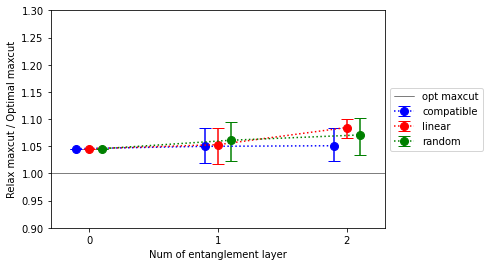

In [3]:
plot_relax_maxcut_results_with_error_bar(
    cost_history_compatible_dict,
    cost_history_linear_dict,
    cost_history_random_dict,
    3,
    30,
    3,
    [
        -compatible_results_dict[3][30][i][0]["optimum_solution"]
        for i in range(num_trials)
    ],
)

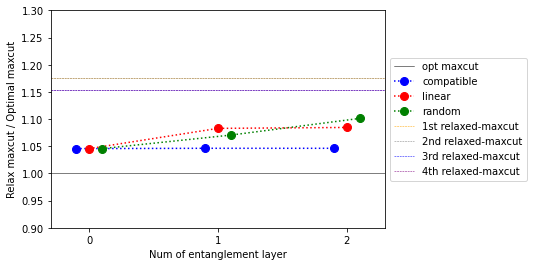

In [4]:
plot_relax_maxcut_results_for_instance(
    eigvals_dict,
    cost_history_compatible_dict,
    cost_history_linear_dict,
    cost_history_random_dict,
    3,
    30,
    3,
    [
        -compatible_results_dict[3][30][i][0]["optimum_solution"]
        for i in range(num_trials)
    ],
    0,
)

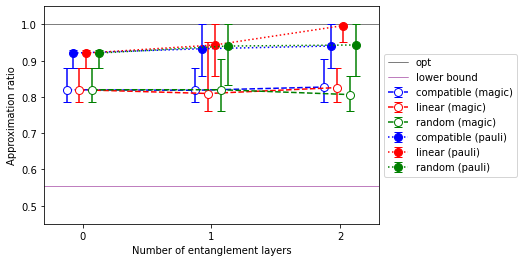

In [5]:
plot_rounding_results_with_error_bar(
    compatible_results_dict,
    linear_results_dict,
    random_results_dict,
    3,
    30,
    3,
    16,
)

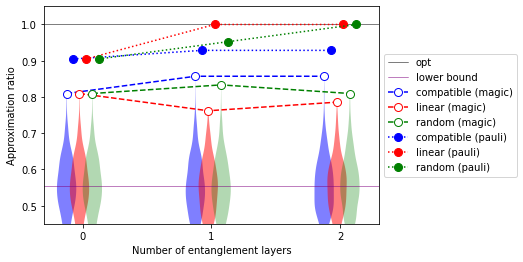

In [6]:
plot_rounding_results_for_instance(
    compatible_results_dict,
    linear_results_dict,
    random_results_dict,
    3,
    30,
    3,
    0,
)

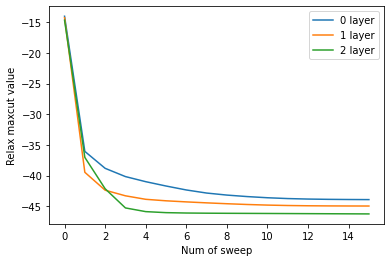

In [7]:
plot_cost_history_by_entanglement(
    eigvals_dict,
    cost_history_compatible_dict,
    cost_history_linear_dict,
    cost_history_random_dict,
    3,
    30,
    0,
    "random",
    False,
)

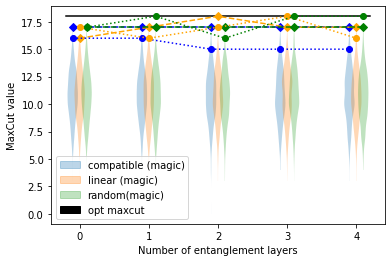

In [5]:
plot_rounding_results_for_instance(
    compatible_results_dict, linear_results_dict, random_results_dict, 3, 14, 0, 5
)

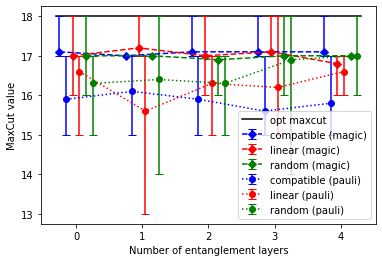

In [6]:
plot_rounding_results_with_error_bar(
    compatible_results_dict, linear_results_dict, random_results_dict, 3, 14, 5
)

In [56]:
from analysis import calc_statistics, plot_maxcut_results

compatible_values_max_pauli_dict = defaultdict(lambda: {}, {})
linear_values_max_pauli_dict = defaultdict(lambda: {}, {})
random_values_max_pauli_dict = defaultdict(lambda: {}, {})
compatible_values_max_magic_dict = defaultdict(lambda: {}, {})
linear_values_max_magic_dict = defaultdict(lambda: {}, {})
random_values_max_magic_dict = defaultdict(lambda: {}, {})
compatible_values_exp_magic_dict = defaultdict(lambda: {}, {})
linear_values_exp_magic_dict = defaultdict(lambda: {}, {})
random_values_exp_magic_dict = defaultdict(lambda: {}, {})
compatible_values_freq_magic_dict = defaultdict(lambda: {}, {})
linear_values_freq_magic_dict = defaultdict(lambda: {}, {})
random_values_freq_magic_dict = defaultdict(lambda: {}, {})
opt_values_dict = defaultdict(lambda: {}, {})

for deg in degs:
    for num_nodes in num_nodes_list:
        (
            compatible_values_max_pauli,
            linear_values_max_pauli,
            random_values_max_pauli,
            compatible_values_max_magic,
            linear_values_max_magic,
            random_values_max_magic,
            compatible_values_exp_magic,
            linear_values_exp_magic,
            random_values_exp_magic,
            compatible_values_freq_magic,
            linear_values_freq_magic,
            random_values_freq_magic,
            opt_values,
        ) = calc_statistics(
            graphs_dict,
            compatible_results_dict,
            linear_results_dict,
            random_results_dict,
            deg,
            num_nodes,
        )
        compatible_values_max_pauli_dict[deg][num_nodes] = compatible_values_max_pauli
        linear_values_max_pauli_dict[deg][num_nodes] = linear_values_max_pauli
        random_values_max_pauli_dict[deg][num_nodes] = random_values_max_pauli
        compatible_values_max_magic_dict[deg][num_nodes] = compatible_values_max_magic
        linear_values_max_magic_dict[deg][num_nodes] = linear_values_max_magic
        random_values_max_magic_dict[deg][num_nodes] = random_values_max_magic
        compatible_values_exp_magic_dict[deg][num_nodes] = compatible_values_exp_magic
        linear_values_exp_magic_dict[deg][num_nodes] = linear_values_exp_magic
        random_values_exp_magic_dict[deg][num_nodes] = random_values_exp_magic
        compatible_values_freq_magic_dict[deg][num_nodes] = compatible_values_freq_magic
        linear_values_freq_magic_dict[deg][num_nodes] = linear_values_freq_magic
        random_values_freq_magic_dict[deg][num_nodes] = random_values_freq_magic
        opt_values_dict[deg][num_nodes] = opt_values

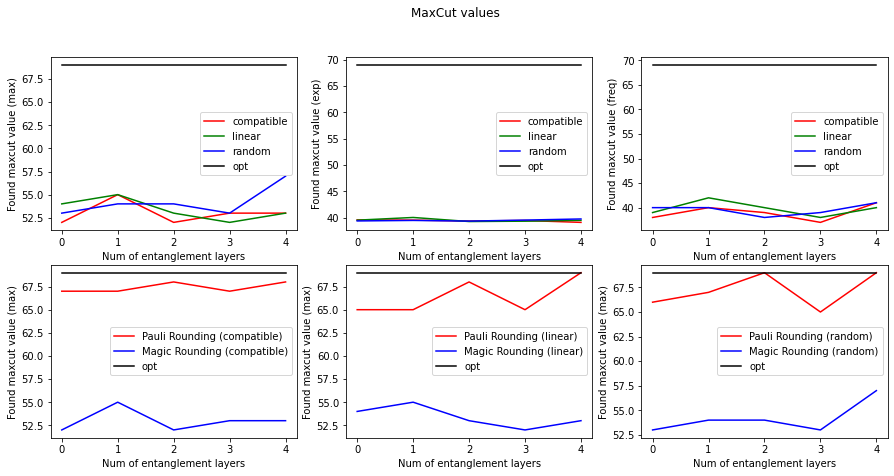

In [62]:
plot_maxcut_results(
    compatible_values_max_pauli_dict,
    linear_values_max_pauli_dict,
    random_values_max_pauli_dict,
    compatible_values_max_magic_dict,
    linear_values_max_magic_dict,
    random_values_max_magic_dict,
    compatible_values_exp_magic_dict,
    linear_values_exp_magic_dict,
    random_values_exp_magic_dict,
    compatible_values_freq_magic_dict,
    linear_values_freq_magic_dict,
    random_values_freq_magic_dict,
    opt_values_dict,
    3,
    52,
    True,
)

In [3]:
import numpy as np
from qiskit.opflow import I, X, Y, Z

H = (I ^ I ^ I ^ I) + (Z ^ Z ^ I ^ I)

In [7]:
H = 0
for (i, j) in [(1, 2), (2, 3)]:
    for k in range(4):
        if k == i or k == j:
            tmp_H ^= Z
        else:
            tmp_H ^= I
    H += tmp_H

ExtensionError: 'Input matrix is not unitary.'